In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from models import Pyt_Attention_Xformer as Xformer
from sklearn.manifold import TSNE
import numpy as np
import torch

In [2]:
## Device toggle
device = torch.device("mps")
# device = torch.device("cpu")

In [3]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
vocab_size = len(vocab) + 1 # Blank token
block_length = max_length + 1
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [4]:
# ## Hyperparameters
emb_dim = 64
num_heads = 4
dropout = 0.2

In [5]:
# class  MultiHeadAttention(nn.Module):
#     def __init__(self, num_heads, emb_dim):
#         super().__init__()
#         self.heads = nn.MultiheadAttention(emb_dim, num_heads, dropout=dropout, bias=False)

#     def forward(self, x):
#         x = self.heads(x,x,x)
#         return x

In [6]:
# class Feedforward(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.ff = nn.Sequential(
#             nn.Linear(emb_dim, 4*emb_dim),
#             nn.ReLU(),
#             nn.Linear(4*emb_dim, emb_dim),
#             nn.Dropout(dropout)
#         )

#     def forward(self,x):
#         return self.ff(x)

In [7]:
# class Block(nn.Module):
#     def __init__(self, emb_dim, num_heads):
#         super().__init__()
#         self.head_size = emb_dim // num_heads
#         self.sa_head = MultiHeadAttention(self.head_size, num_heads, emb_dim)
#         self.ff = Feedforward(emb_dim)
#         self.ln1 = nn.LayerNorm(emb_dim)
#         self.ln2 = nn.LayerNorm(emb_dim)

#     def forward(self, x, targets=None):
#         sa_out, sq_wte = self.sa_head(self.ln1(x))
#         x = x + sa_out
#         x = x + self.ff(self.ln2(x))
#         return x

In [8]:
# class Xformer(nn.Module):
#     def __init__(self, emb_dim, num_heads):
#         super().__init__()
#         self.token_embedding = nn.Embedding(vocab_size + 1, emb_dim)
#         self.pos_embedding = nn.Embedding(vocab_size + 1, emb_dim)
#         # self.sa_head = MultiHeadAttention(emb_dim//4, 4, emb_dim, block_length)
#         # self.ff = Feedforward(emb_dim)
#         self.blocks = nn.Sequential(
#             Block(emb_dim, num_heads=4), 
#             Block(emb_dim, num_heads=4),
#             Block(emb_dim, num_heads=4),
#             nn.LayerNorm(emb_dim)
#         )
#         self.lm_head = nn.Linear(emb_dim, vocab_size)

#     def forward(self, x, targets=None):
#         tok_emb = self.token_embedding(x)
#         pos_emb = self.pos_embedding(x)
#         x = tok_emb + pos_emb # B, T, emb_dim
#         # x = self.sa_head(x) # B, T, head_size
#         # x =  self.ff(x)
#         x = self.blocks(x)
#         logits = self.lm_head(x) # B, T, vocab_size

#         # if we are given some desired targets also calculate the loss
#         loss = None
#         if targets is not None:
#             # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

#         return(logits,loss)

In [9]:
# # Test run on a batch size of 1 for debug
# batch_size = 1
# train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# model = Xformer(emb_dim, vocab_size, num_heads, dropout).to(device)
# optimizer = Adam(model.parameters(), lr=0.01)
# xb, yb = next(iter(train_dataloader))
# xb = xb.to(device)
# yb = yb.to(device)
# # print(xb.shape, yb.shape)
# logits, loss = model(xb,yb)
# print(loss)

In [10]:
# Set up optimizer and model
batch_size = 512
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(emb_dim, vocab_size, num_heads, dropout).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

Text(0, 0.5, 'Loss')

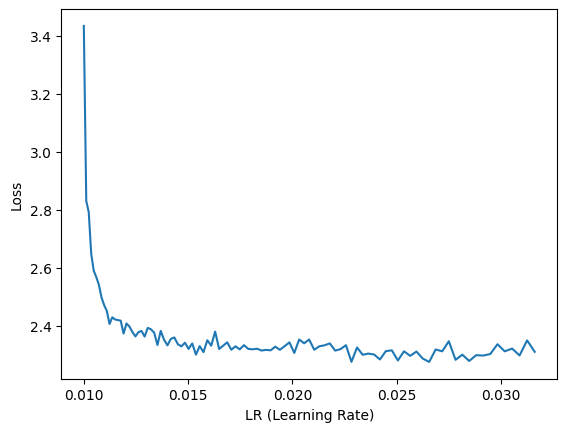

In [11]:
# ## Optimal lr sweep
import matplotlib.pyplot as plt
num_epochs = 100
lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -2, -1.5)
plt.plot(lri, lossi)
# Add labels to the x-axis and y-axis
plt.xlabel('LR (Learning Rate)')
plt.ylabel('Loss')

In [12]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [13]:
# Training loop 
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

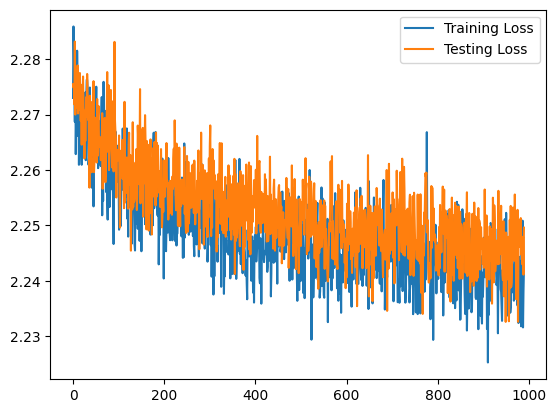

training loss:  2.2412
validation loss:  2.2459


In [14]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss[10:], label='Training Loss')
plt.plot(te_loss[10:], label='Testing Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [18]:
## Pretty print the samples
print_samples(model, train_data, max_length, device, num=32)

jeann
bmisi
kinama
weiveren
macea
loccen
revanal
kercll
iller
cre
adayvann
faamintattta
brime
emnan
kiletra
trbiyn
jamia
auxi
kadio
arakyl
laish
lala
mandold
lullyn
jaisstie
ambriein
nyleona
kalche
yaoz
bry
hanmia
kaimyna


['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'blank']


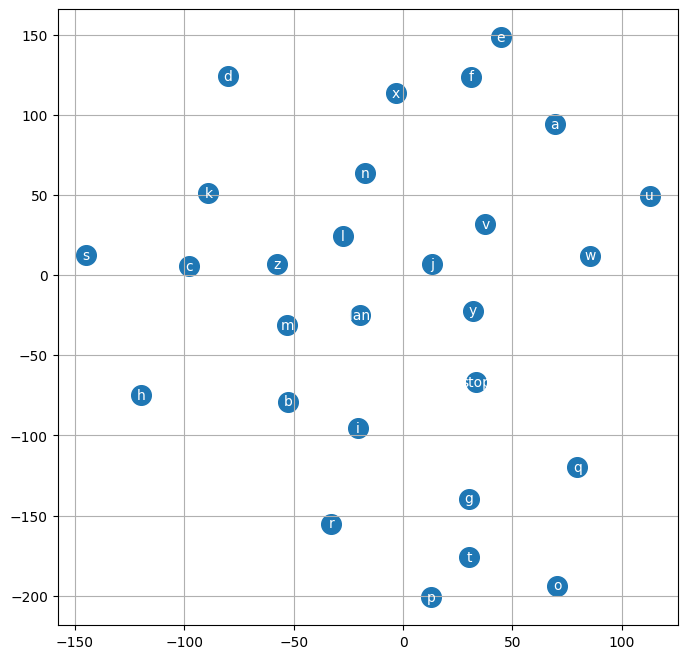

In [19]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=7)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')